<a href="https://colab.research.google.com/github/mmtdmackonal/spoofed-audio-detector/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd 
import os 
import glob
import soundfile as sf
import scipy.io.wavfile
import scipy.signal as signal
import matplotlib.pyplot as plt
import pathlib
import shutil
import random

from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import time
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = "/content/drive/MyDrive/FYP-5704-MTD MACKONAL/image data set/ImageData"


In [ ]:
print(len(os.listdir(dataset_path + "/Spectograms")))

3028


In [ ]:
# Define Constants
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### Data Preparation

In [ ]:
# Read the real and spoof spectrogram images from directory
filename1 = os.listdir(dataset_path + "/Real/")
filename2 = os.listdir(dataset_path + "/Spoof/")
category1 = []
category2 = []


In [ ]:
# Check the length of the list
print(len(filename1))
print(len(filename2))

1511
1517


In [ ]:
# Shuffle the data randomly
random.shuffle(filename1)
random.shuffle(filename2)

In [ ]:
# Get filename and assign label '0' for real images and stored in dataframe
for filename in filename1:
    category1.append(0)    
df1 = pd.DataFrame({ 'filename': filename1,'category': category1 })    

# Get filename and assign label '1' for TTS fake images and stored in dataframe
for filename in filename2:
    category2.append(1)    
df2 = pd.DataFrame({ 'filename': filename2, 'category': category2 })


In [ ]:
# Combined the dataframes
frames = [df1, df2]
df = pd.concat(frames)

In [ ]:
df.head()

,filename,category
0,T_1000688.wav.png,0
1,T_1001267.wav.png,0
2,T_1000458.wav.png,0
3,T_1000764.wav.png,0
4,T_1000926.wav.png,0


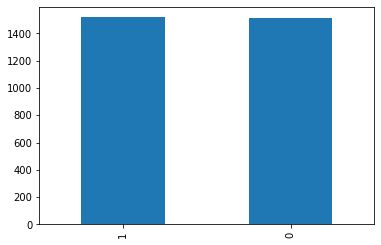

In [ ]:
df['category'].value_counts().plot.bar()

In [ ]:
# Replace output label data
df["category"] = df["category"].replace({0: 'Real', 1: 'Spoof'}) 

In [ ]:
# Data splitting into train and test data and keep this test data aside for model prediction

trainData_df, testData_df = train_test_split(df, test_size=0.20, random_state=42)
trainData_df = trainData_df.reset_index(drop=True)
testData_df = testData_df.reset_index(drop=True)

In [ ]:
# Again split the above train data into new train dataset (used to train the model ) 
# and validation set
train_df, validate_df = train_test_split(trainData_df, test_size=0.10, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

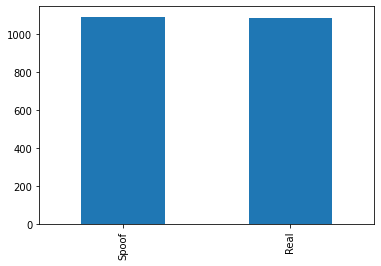

In [ ]:
train_df['category'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
total_test = testData_df.shape[0]
batch_size=15

### Building and Training Model 

In [ ]:
# generic image data generator 
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
# # Train image data generator
# # Create new train folder directory which should have both the images real and fake combined.
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    dataset_path + "/Spectograms", 
    x_col='filename',
    y_col='category',
    seed=30,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2179 validated image filenames belonging to 2 classes.


In [ ]:
# Validation image data generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    dataset_path + "/Spectograms",
    x_col='filename',
    y_col='category',
    seed=30,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 243 validated image filenames belonging to 2 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='hinge', optimizer='adam', metrics=['accuracy'])

In [ ]:
# To prevent over fitting , stop the learning after 10 epochs and reduce learning rate after two steps
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

checkpoint_cb = ModelCheckpoint(dataset_path + "/weights/model_weights_new.h5", save_best_only=True)

In [ ]:
# Saved callbacks parameters
callbacks = [checkpoint_cb, earlystop, learning_rate_reduction]

In [ ]:
epochs=5 if FAST_RUN else 25
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch= 100, #total_train//batch_size, 
    #[Originally steps per epoch should be total_train//batch_size but for now lets try with 50]
    callbacks=callbacks
)

Epoch 1/25
100/100 [==============================] - 32s 284ms/step - loss: 0.6613 - accuracy: 0.8039 - val_loss: 9.0968 - val_accuracy: 0.5542 - lr: 0.0010
Epoch 2/25
100/100 [==============================] - 26s 260ms/step - loss: 0.4097 - accuracy: 0.8435 - val_loss: 8.5602 - val_accuracy: 0.5542 - lr: 0.0010
Epoch 3/25
100/100 [==============================] - ETA: 0s - loss: 0.3921 - accuracy: 0.8367
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
100/100 [==============================] - 24s 244ms/step - loss: 0.3921 - accuracy: 0.8367 - val_loss: 13.9372 - val_accuracy: 0.5458 - lr: 0.0010
Epoch 4/25
100/100 [==============================] - 23s 235ms/step - loss: 0.3400 - accuracy: 0.8717 - val_loss: 15.1606 - val_accuracy: 0.5500 - lr: 5.0000e-04
Epoch 5/25
100/100 [==============================] - 24s 239ms/step - loss: 0.2904 - accuracy: 0.8959 - val_loss: 11.3691 - val_accuracy: 0.5708 - lr: 5.0000e-04
Epoch 6/25
100/100 [==================

### Testing Model

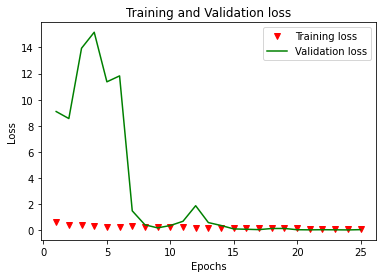

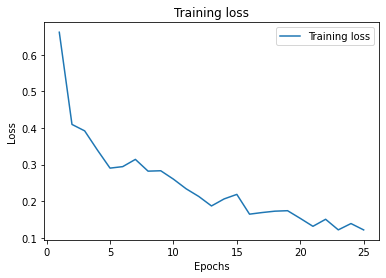

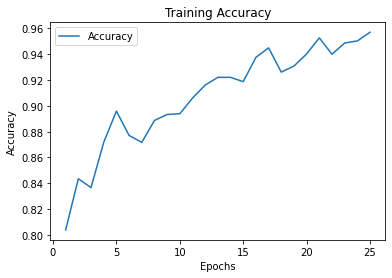

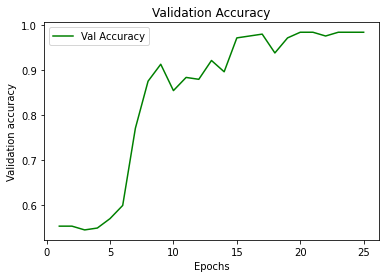

In [ ]:
def visualize(loss, val_loss):
    '''
    Plots a graph for training and validation loss and accuracy
    '''
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs,loss,'rv',label='Training loss')
    plt.plot(epochs,val_loss,'g',label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def visualize1(loss):
    '''
    Plots a graph for training loss and accuracy
    '''
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs,loss,label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def visualize2(accuracy):
    '''
    Plots a graph for accuracy
    '''
    epochs = range(1,len(accuracy)+1)
    plt.figure()
    plt.plot(epochs,accuracy,label='Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def visualize3(val_accuracy):
    '''
    Plots a graph for val accuracy
    '''
    epochs = range(1,len(val_accuracy)+1)
    plt.figure()
    plt.plot(epochs,val_accuracy,'g', label='Val Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Validation accuracy')
    plt.legend()
    plt.show()

visualize(history.history['loss'], history.history['val_loss'])
visualize1(history.history['loss'])
visualize2(history.history['accuracy'])
visualize3(history.history['val_accuracy'])

In [ ]:
# Used above created test dataset for test image data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    testData_df, 
    dataset_path + "/Spectograms",
    x_col='filename',
    y_col='category',
    seed=30,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 606 validated image filenames belonging to 2 classes.


In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(total_test/batch_size), verbose= 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


41/41 [==============================] - 6s 146ms/step


In [ ]:
predict

array([[1.4310707e-02, 9.8568928e-01],
       [9.9729037e-01, 2.7096996e-03],
       [9.9361187e-01, 6.3881027e-03],
       ...,
       [9.9981397e-01, 1.8605255e-04],
       [8.6298544e-04, 9.9913698e-01],
       [9.9836081e-01, 1.6391855e-03]], dtype=float32)

In [ ]:
testData_df['Pred_category'] = np.argmax(predict, axis=1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
testData_df['Pred_category'] = testData_df['Pred_category'].replace(label_map)

<Figure size 432x288 with 0 Axes>

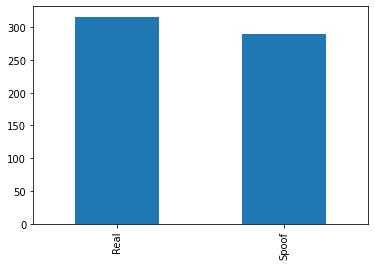

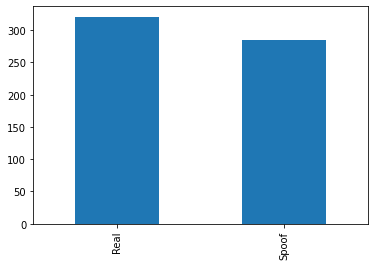

In [ ]:
plt.figure()
plt.subplots(1,1)
testData_df['category'].value_counts().plot.bar()
plt.subplots(1,1)
testData_df['Pred_category'].value_counts().plot.bar()
plt.show()

In [ ]:
testData_df['category'].value_counts()

Real     316
Spoof    290
Name: category, dtype: int64

In [ ]:
testData_df['Pred_category'].value_counts()

Real     321
Spoof    285
Name: Pred_category, dtype: int64

In [ ]:
print('Prediction Accuracy =', metrics.accuracy_score(testData_df['category'], testData_df['Pred_category']))

Prediction Accuracy = 0.4900990099009901


### Inference Pipeline

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import soundfile as sf
import cv2

In [ ]:
model = tf.keras.models.load_model(dataset_path + '/weights/model_weights.h5')

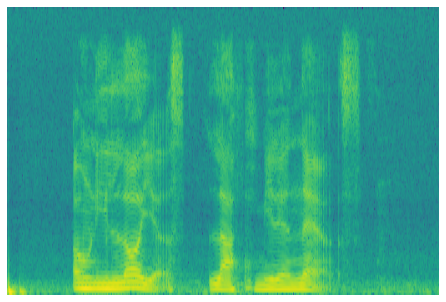

<Figure size 432x288 with 0 Axes>

In [ ]:
y, sr = sf.read(dataset_path + '/sample_audio/E_1000001.wav')
plt.specgram(y,Fs=sr);
plt.axis('off');
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0);
plt.savefig('/content/1.png')
plt.show()
plt.clf()

In [ ]:
y = np.resize(y, (128, 128, 3))
y = np.expand_dims(y, axis=0)
model.predict(y)

array([[1.000000e+00, 3.608086e-13]], dtype=float32)

In [ ]:
image = cv2.imread('/content/1.png')
image = cv2.resize(image, (128, 128))
image = np.expand_dims(image, axis=0)
image.shape
# model.predict()

(1, 128, 128, 3)

ValueError: ignored